In [1]:
import math ; pi=math.pi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import time

In [2]:
# Import PySSC module
import PySSC

## Define window function

In [4]:
# z bins of the survey
zstakes = np.linspace(0.2,1.5,num=14)
zmin = np.min(zstakes) ; zmax = np.max(zstakes)
# Define redshift range
nz       = 500
z_arr    = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
# Window function
nbins_T   = len(zstakes)-1
windows_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>zminbin) and (z<=zmaxbin)):
            windows_T[i,iz] = 1/Dz

## Compute Sij for full sky

In [6]:
# Uses original function, for the full sky
t0 = time.clock()
Sijw_full = PySSC.Sij(z_arr,windows_T)
# Uses the partial sky Sij function, but for a full sky mask (long time)
t1 = time.clock()
Sijw_part = PySSC.Sij_psky(z_arr,windows_T,clmask=None,mask='./mask/full_sky_map.fits') #long computation
t2 = time.clock()
print(t1-t0,t2-t0)

Using mask map, given as a fits file
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
lmax = 102
f_sky = 1.00
3.5739520000000002 271.213218


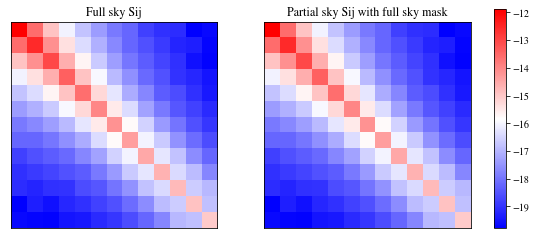

In [7]:
# Compare results
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(8,3.5))
im = axes[0].imshow(np.log(abs(Sijw_full)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
im2 = axes[1].imshow(np.log(abs(Sijw_part)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
for ax in axes:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
axes[0].set_title('Full sky Sij')
axes[1].set_title('Partial sky Sij with full sky mask')
fig.subplots_adjust(left=0.02,bottom=0.08,top=0.9,wspace=0.002)
cbar_ax = fig.add_axes([0.9, 0.08, 0.02, 0.87])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=.5)
plt.show()

## Compute partial sky Sij for DES

Computing Sij for DES mask
Using mask map, given as a fits file
lmax = 102
f_sky = 0.12
Done in 4.43 minutes


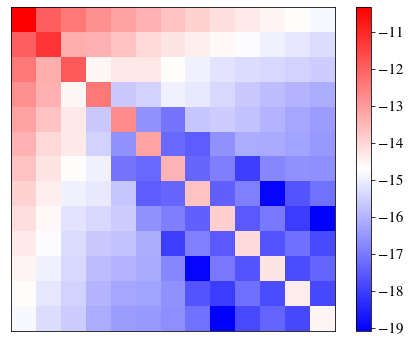

In [5]:
print('Computing Sij for DES mask')
t3 = time.clock()
Sijw_part_DES = PySSC.Sij_psky(z_arr,windows_T,clmask=None,mask='./mask/DES-mask-simple-ring-1024.fits')
t4 = time.clock()
print('Done in %.2f minutes' %((t4-t3)/60))
fig = plt.figure(figsize=(6.,5)) 
ax = fig.add_axes([0.05,0.05,0.75,0.9]) 
P = ax.imshow(np.log(abs(Sijw_part_DES)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin]) 
plt.xticks([]) ; plt.yticks([]) 
ax1 = fig.add_axes([0.85, 0.05, 0.035, 0.9]) 
cbar = plt.colorbar(P,ax1) 
cbar.ax.tick_params(labelsize=15) 
plt.show()